# Occupancy Detection from RPi
Using CO$_2$ data from the BEVO Beacon to estimate occupancy.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from src.visualization import visualize

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math

from datetime import datetime, timedelta

# Data Import
We need all the BEVO Beacon's measurements of the CO$_2$ concentration, but we might also consider metrics like TVOCs, Temperature, and RH.

In [2]:
beacon = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],infer_datetime_format=True)

In addition, we need the filtered dataset to compare readings to.

In [3]:
beacon_filtered = pd.read_csv("../data/processed/beacon_by_night-bad_nights_included-ux_s20.csv",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)

Fitbit data will be needed to look at sleep periods.

In [4]:
fitbit = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",parse_dates=["start_time","end_time","date"],infer_datetime_format=True)

# Simple Occupancy Estimation
We can start by simply looking at nights that we _know_ the participant is home and occupying the space. Then we can use that information to determine other nights when the participant would have been asleep in their bedroom by comparing, as a start, the median/mean concentration.

In [5]:
class co2_inspection:
    
    def __init__(self,pt,data_dir="../"):
        self.pt = pt # beiwe id
        # beacon data
        complete = pd.read_csv(f"{data_dir}data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],infer_datetime_format=True)
        filtered = pd.read_csv(f"{data_dir}data/processed/beacon_by_night-bad_nights_included-ux_s20.csv",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
        self.complete = complete[complete["beiwe"] == self.pt]
        self.filtered = filtered[filtered["beiwe"] == self.pt]
        self.filtered = self.filtered[(self.filtered["home"] == 1) | (self.filtered["increasing_co2"] > 0.5)]
        self.s = pd.Series(self.filtered["start_time"].unique())
        # fitbit data
        fitbit = pd.read_csv(f"{data_dir}data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"],infer_datetime_format=True)
        self.sleep = fitbit[fitbit["beiwe"] == self.pt]
        # gps data
        gps = pd.read_csv(f"{data_dir}data/processed/beiwe-gps-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
        self.gps = gps[gps["beiwe"] == self.pt]
        # beacon data derivatives
        #self.set_morning_beacon_data()
        #self.set_beacon_before_sleep()
        #self.set_increasing_periods(self.complete,"co2")
        #self.set_increasing_periods(self.filtered,"co2")
        #self.set_increasing_only()
        #self.set_beacon_by_sleep()
        #self.set_beacon_while_occupied()
        #self.set_beacon_gps_occupied()
        
    def set_morning_beacon_data(self,time_column="timestamp",num_hours=3):
        """gets the beacon data from the morning"""
        morning_df = pd.DataFrame()
        all_data = self.complete.copy()
        all_data.set_index(time_column,inplace=True)
        for wake_time in self.filtered['end_time'].unique():
            temp = all_data[wake_time:pd.to_datetime(wake_time)+timedelta(hours=num_hours)]
            temp['start_time'] = wake_time
            morning_df = morning_df.append(temp)

        self.morning = morning_df.reset_index()
        
    def set_beacon_before_sleep(self,time_column="timestamp",num_hours=1):
        """sets beacon data prior to sleeping"""
        prior_to_sleep_df = pd.DataFrame()
        all_data = self.complete.copy()
        all_data.set_index(time_column,inplace=True)
        for sleep_time in self.filtered['start_time'].unique():
            temp = all_data[pd.to_datetime(sleep_time)-timedelta(hours=num_hours):pd.to_datetime(sleep_time)+timedelta(hours=1)]
            temp['end_time'] = sleep_time
            prior_to_sleep_df = prior_to_sleep_df.append(temp)

        self.prior = prior_to_sleep_df.reset_index()
        
    def plot_timeseries(self,df,variable,time_column="timestamp",re=False,**kwargs):
        """plots timeseries of the given variable"""
        fig, ax = plt.subplots(figsize=(24,4))
        try:
            if "time_period" in kwargs.keys():
                df = df.set_index(time_column)[kwargs["time_period"][0]:kwargs["time_period"][1]].reset_index()
            # plotting
            ax.scatter(df[time_column],df[variable],color="black",s=10)
            # formatting
            if "event" in kwargs.keys():
                ax.axvline(kwargs["event"],linestyle="dashed",linewidth=3,color="firebrick")
            if "ylim" in kwargs.keys():
                ax.set_ylim(kwargs["ylim"])
                
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)

            if re:
                return ax
            
            plt.show()
            plt.close()
        except Exception as e:
            print(e)
            
    def plot_individual_days(self,dataset,variable="co2",**kwargs):
        """plots the individual days"""
        t = "start_time" if "start_time" in dataset.columns else "end_time"
        print(t)
        for event in dataset[t].unique():
            timeseries(dataset[dataset[t] == event],variable,event=pd.to_datetime(event),**kwargs)
            
    def set_increasing_periods(self,dataset,variable,averaging_window=60,increase_window=5,stat="mean",plot=False):
        """finds increasing periods"""
         # smooting data
        if stat == "mean":
            dataset[f"sma_{variable}"] = dataset[variable].rolling(window=averaging_window,center=True,min_periods=int(averaging_window/2)).mean()
        else:
            dataset[f"sma_{variable}"] = dataset[variable].rolling(window=averaging_window,center=True,min_periods=int(averaging_window/2)).median()
        dataset["dC"] = dataset[f"sma_{variable}"] - dataset[f"sma_{variable}"].shift(1) # getting dC
        dataset["sma_dC"] = dataset["dC"].rolling(window=increase_window).mean() # getting moving average of increases
        inc = []
        for value in dataset["sma_dC"]:
            if math.isnan(value):
                inc.append(np.nan)
            elif value > 0:
                inc.append(1)
            else:
                inc.append(0)
        dataset["increasing"] = inc
        #dataset["increasing"] = [1 if value > 0 else 0 for value in dataset["sma_dC"]] # creating column for increasing concentration
        
        if plot:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.scatter(self.complete["timestamp"],self.complete[variable],color="black",s=10,alpha=0.7,zorder=1)
            inc = dataset[dataset["increasing"] == 1]
            ax.scatter(inc["timestamp"],inc[variable],color="seagreen",s=5,zorder=2)
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
                
    def set_increasing_only(self):
        """beacon data over increasing periods only"""
        self.inc = self.complete[self.complete["increasing"] == 1]
    
    def set_beacon_by_sleep(self):
        """beacon data during sleep events"""
        beacon_by_fitbit = pd.DataFrame()
        for s, e in zip(self.filtered["start_time"].unique(),self.filtered["end_time"].unique()):
            beacon_temp = self.complete.set_index("timestamp")[pd.to_datetime(s):pd.to_datetime(e)].reset_index()
            beacon_temp["start_time"] = s
            beacon_temp["end_time"] = e
            beacon_by_fitbit = beacon_by_fitbit.append(beacon_temp)
            
        self.beacon_during_sleep = beacon_by_fitbit
        
    def set_beacon_while_occupied(self,threshold=0.75):
        """beacon data when the bedroom is occupied"""
        beacon_percent = self.beacon_during_sleep.drop(["sma_co2","dC","sma_dC","increasing"],axis="columns").merge(right=self.beacon_during_sleep.groupby("start_time").mean().reset_index()[["increasing","start_time"]],on="start_time",how="left")
        self.occupied = beacon_percent[beacon_percent["increasing"] > threshold]
        
    def set_beacon_gps_occupied(self):
        """beacon data when occupied or gps confirms home"""
        self.fully_filtered = self.filtered.append(self.occupied).drop_duplicates(subset=["beiwe","timestamp"])
        
    def plot_overlap(self, **kwargs):
        fig, t_ax = plt.subplots(figsize=(29,6))
        # temperature axis
        try:
            t_ax.scatter(self.complete["timestamp"],self.complete["temperature_c"],color="cornflowerblue",s=5,marker="s")
        except AttributeError:
            print("no temperature data")
        plt.xticks(rotation=-30,ha="left")
        ## y-axis
        t_ax.set_ylim([10,40])
        t_ax.set_ylabel("Temperature (C)",fontsize=14)
        t_ax.yaxis.label.set_color('cornflowerblue')
        t_ax.tick_params(axis='y', colors='cornflowerblue',labelsize=12) 
        # co2 axis
        ax = t_ax.twinx()
        ## sleep events
        night_counter = 0
        if "time_period" in kwargs.keys():
            starting = kwargs["time_period"][0]
            ending = kwargs["time_period"][1]
        else:
            starting = datetime(1900,1,1)
            ending = datetime(2021,1,1)
        for s, e in zip(self.filtered["start_time"].unique(),self.filtered["end_time"].unique()):
            if pd.to_datetime(s) > starting and pd.to_datetime(e) < ending:
                ax.text(pd.to_datetime(s),np.nanmax(self.complete["co2"]),str(night_counter),fontsize=16,ha="left",va="top")
                ax.axvspan(pd.to_datetime(s),pd.to_datetime(e),color="grey",alpha=0.25,zorder=1)
            night_counter += 1
        ## beacon data
        ax.scatter(self.complete["timestamp"],self.complete["co2"],color="grey",alpha=0.5,s=5,zorder=2,label="Raw Data") # raw
        gps_filtered = self.filtered[self.filtered["home"] == 1]
        ax.scatter(gps_filtered["timestamp"],gps_filtered["co2"],s=20,color="firebrick",zorder=5, label="GPS Confirms Home") # gps filtered
        co2_filtered = self.filtered[self.filtered["increasing_co2"] > 0.5]
        ax.scatter(co2_filtered["timestamp"],co2_filtered["co2"],s=5,color="goldenrod",zorder=6, label="Increasing CO$_2$") # co2 filtered
        ## x-axis
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        plt.xticks(rotation=-30,ha="left")
        if "time_period" in kwargs.keys():
            ax.set_xlim([kwargs["time_period"][0],kwargs["time_period"][1]])
        # y-axis
        ax.set_ylabel("CO$_2$ Concentration (ppm)",fontsize=14)
        ax.yaxis.label.set_color('gray')
        ax.tick_params(axis='y',colors="gray", labelsize=12) 
        # remainder
        ax.spines["top"].set_visible(False)
        ax.legend(frameon=False,loc="upper center",bbox_to_anchor=(0.5,-0.1),ncol=3)

        plt.show()
        plt.close()
            
    def run(self):
        """runs the analysis"""
        for dataset, label in zip([self.complete,self.filtered,self.prior,self.morning],["Complete","Filtered","Before Sleep","After Waking"]):
            print(label)
            self.plot_timeseries(dataset,"co2")

## All Participants
Based on some of the findings above, it is worthwhile to run the analysis for all participants.

In [6]:
print(sorted(beacon_filtered["beiwe"].unique()))
print(len(beacon_filtered["beiwe"].unique()))

['4i7679py', '745vq78e', '9jtzsuu8', '9xmhtq74', 'awa8uces', 'e73a1pd5', 'hxj6brwj', 'i31pt4b4', 'i4w8dx6l', 'idbkjh8u', 'itmylz3g', 'kyj367pi', 'lkkjddam', 'nvtfpaor', 'olaxadz5', 'qh34m4r9', 'rnse61g4', 'tlmlq19s', 'tmexej5v', 'vr9j5rry', 'xdbdrk6e', 'xlw5ntd5', 'zdpffrox']
23


In [7]:
bad_nights = {beiwe: [] for beiwe in beacon_filtered["beiwe"].unique()}

### 4i7679py

In [8]:
fi = co2_inspection(pt="4i7679py")

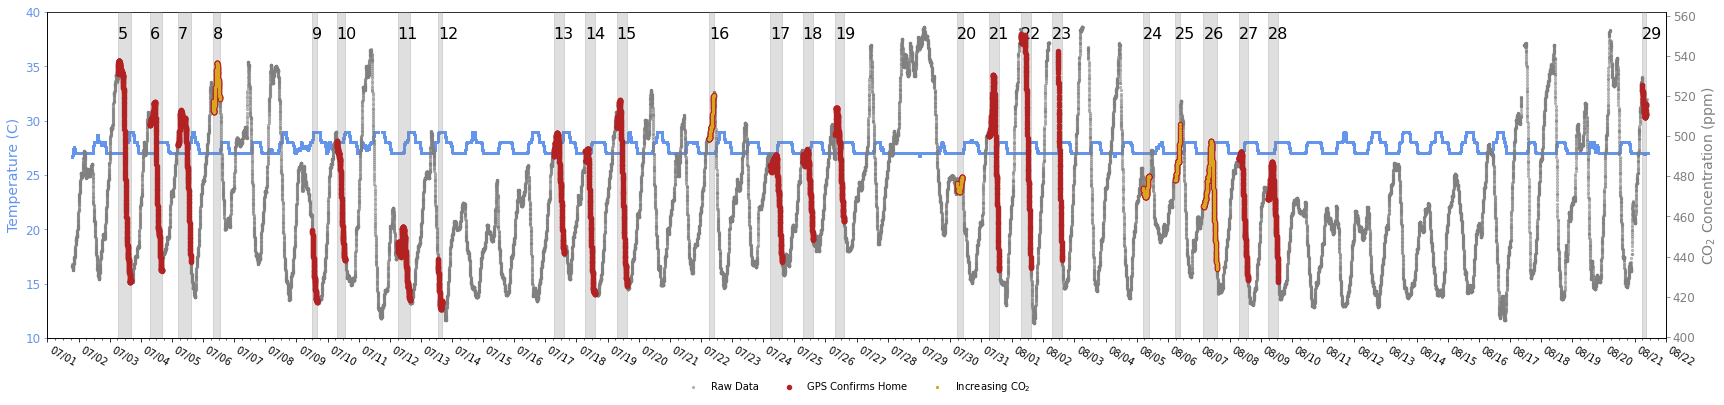

In [9]:
fi.plot_overlap(time_period=[datetime(2020,7,1),datetime(2020,8,22)])

In [10]:
#bad_nights["4i7679py"] = fi.s.iloc[[5,6,7,9,10,11,12,13,14,15,17,18,19,21,22,23,26,27,28]].values

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon

</div>

<div class="alert-block alert alert-success">
    
Include one night from this participant as representative for _bad_ night to exclude.

</div>

### 745vq78e

In [11]:
s4 = co2_inspection(pt="745vq78e")

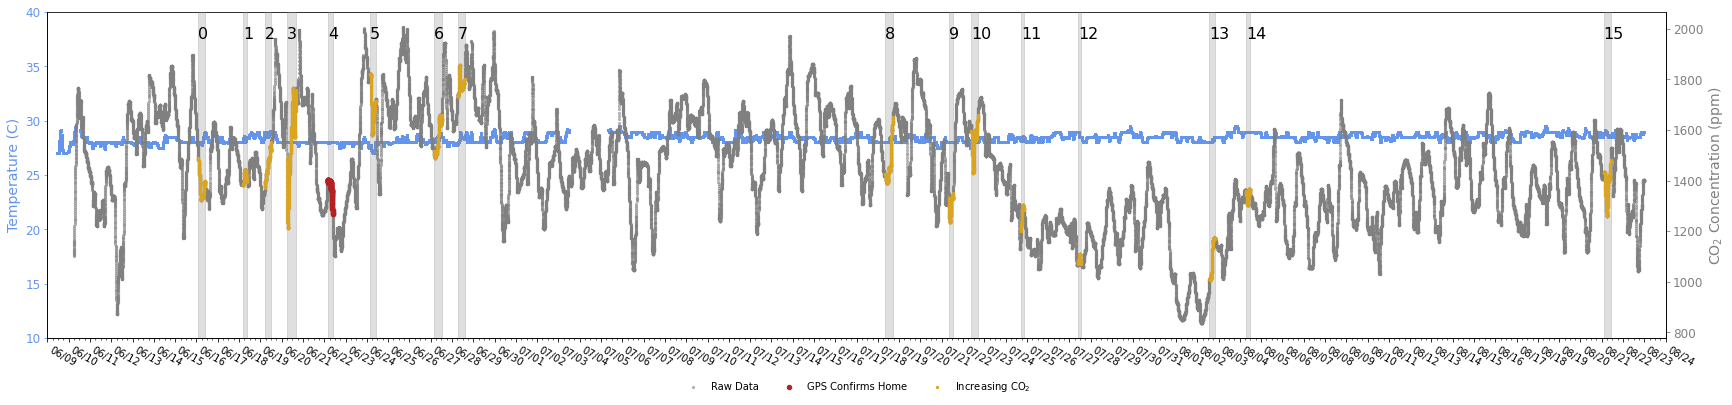

In [12]:
s4.plot_overlap(time_period=[datetime(2020,6,9),datetime(2020,8,24)])

<div class="alert-block alert alert-success">
    
Data makes sense when looking more closely at the temperature/ventilation

</div>

### 9jtzsuu8

In [13]:
nj = co2_inspection(pt="9jtzsuu8")

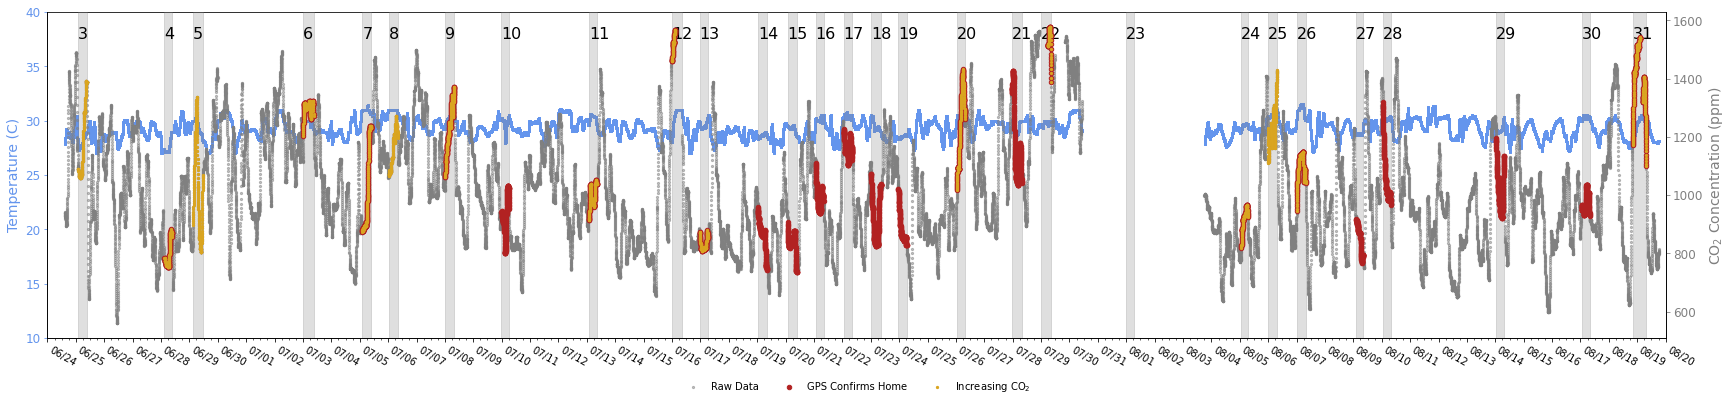

In [14]:
nj.plot_overlap(time_period=[datetime(2020,6,24),datetime(2020,8,20)])

In [15]:
bad_nights["9jtzsuu8"] = nj.s.iloc[[19,27,28]].values

<div class="alert-block alert alert-warning">
    
Data requires more review - there are times when the `co2` is increasing and other times when it is decreasing during sleep events.

</div>

### 9xmhtq74

In [16]:
nx = co2_inspection("9xmhtq74")

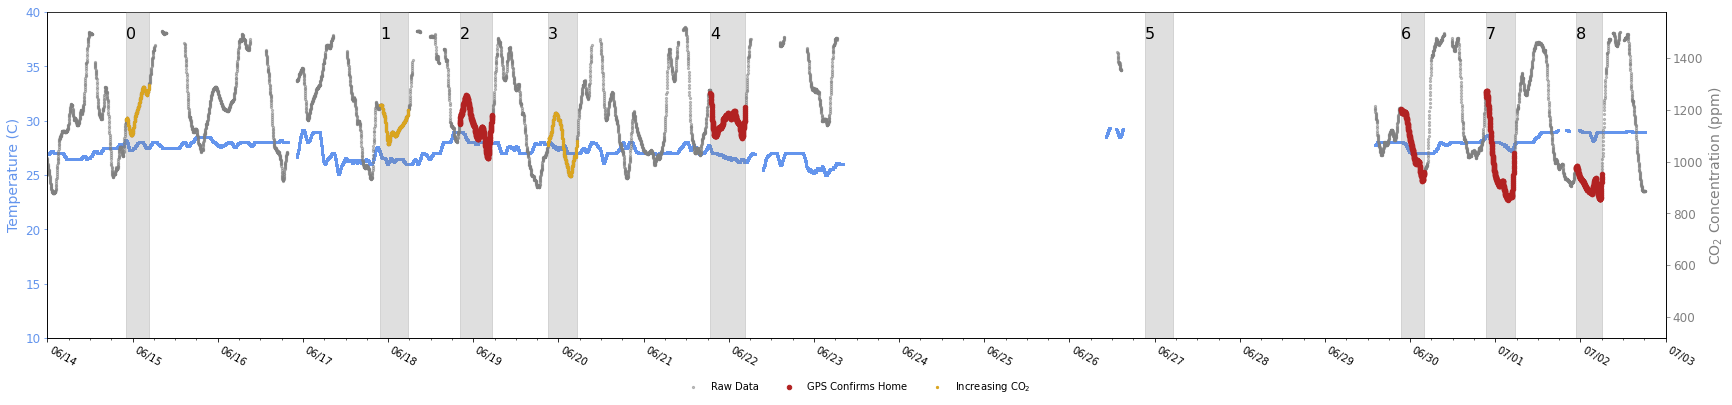

In [17]:
nx.plot_overlap(time_period=[datetime(2020,6,14),datetime(2020,7,3)])

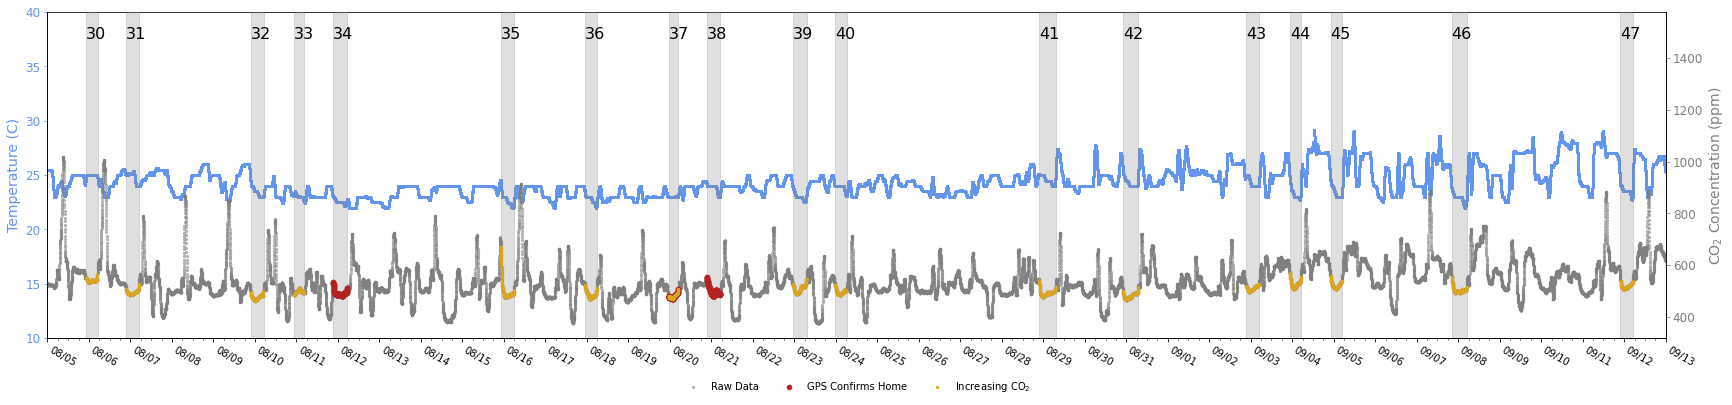

In [18]:
nx.plot_overlap(time_period=[datetime(2020,8,5),datetime(2020,9,13)])

In [19]:
bad_nights["9xmhtq74"] = nx.s.values

<div class="alert-block alert alert-danger">
    
The data isn't very clear but based on the spikes, it seems very likely that the device is not in the bedroom.

</div>

### awa8uces

In [20]:
aw = co2_inspection("awa8uces")

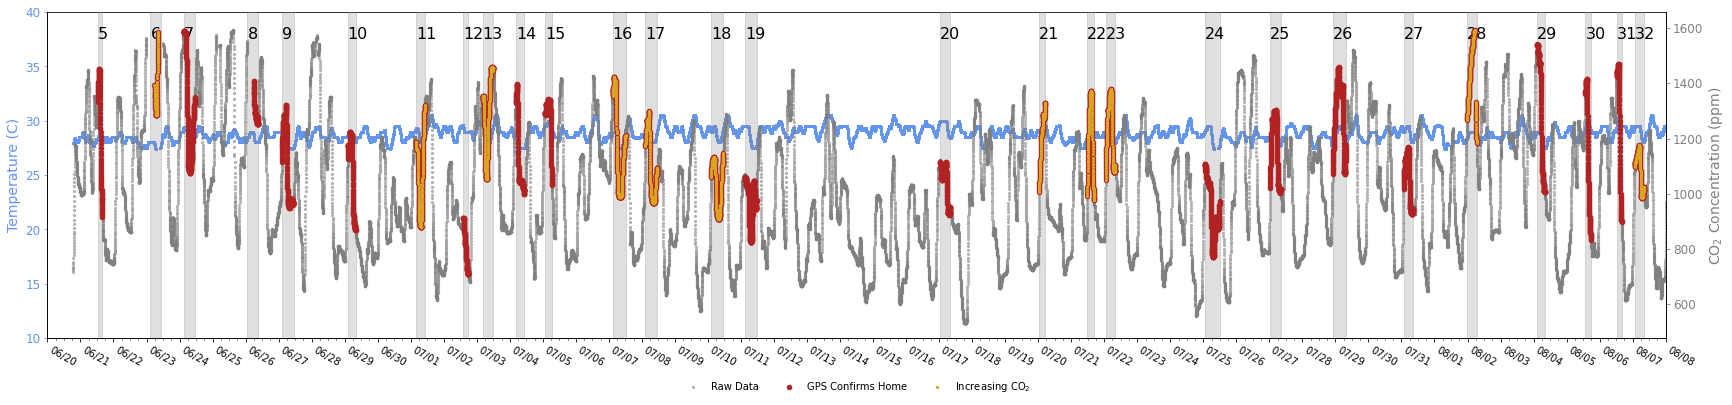

In [21]:
aw.plot_overlap(time_period=[datetime(2020,6,20),datetime(2020,8,8)])

In [22]:
bad_nights["awa8uces"] = aw.s.iloc[[12,]].values

In [23]:
sleep = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv")
sleep_check = sleep[sleep["beiwe"] == "awa8uces"]

<div class="alert-block alert alert-warning">
    
Looks like another living room beacon, but it isn't super clear.

</div>

### e73a1pd5

In [24]:
e7 = co2_inspection("e73a1pd5")

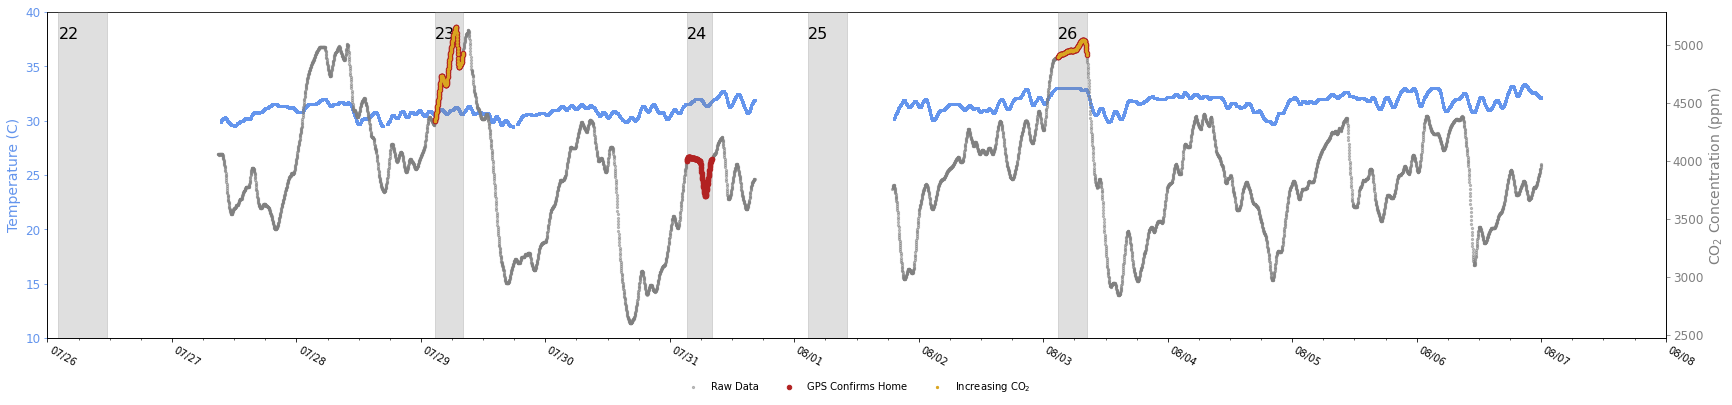

In [25]:
e7.plot_overlap(time_period=[datetime(2020,7,26),datetime(2020,8,8)])

In [26]:
sleep_check = sleep[sleep["beiwe"] == "e73a1pd5"]
#sleep_check[sleep_check["main_sleep"] == False]

<div class="alert-block alert alert-success">
    
These data look fine, but the non-main sleep needs to be removed in the source code.

</div>

### hxj6brwj

In [27]:
hx = co2_inspection("hxj6brwj")

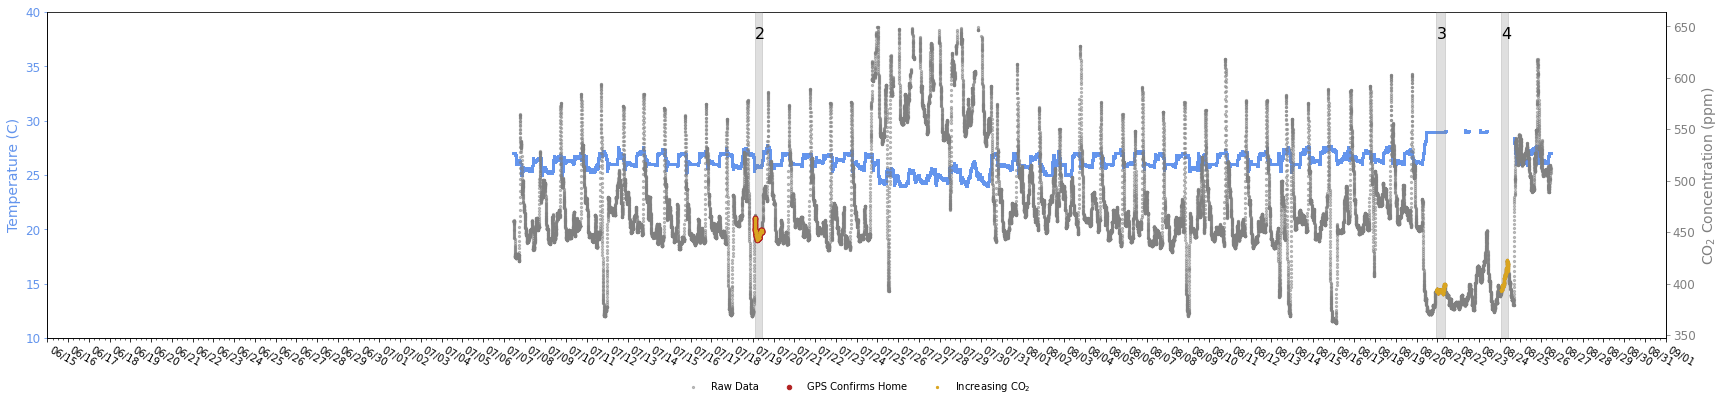

In [28]:
hx.plot_overlap(time_period=[datetime(2020,6,15),datetime(2020,9,1)])

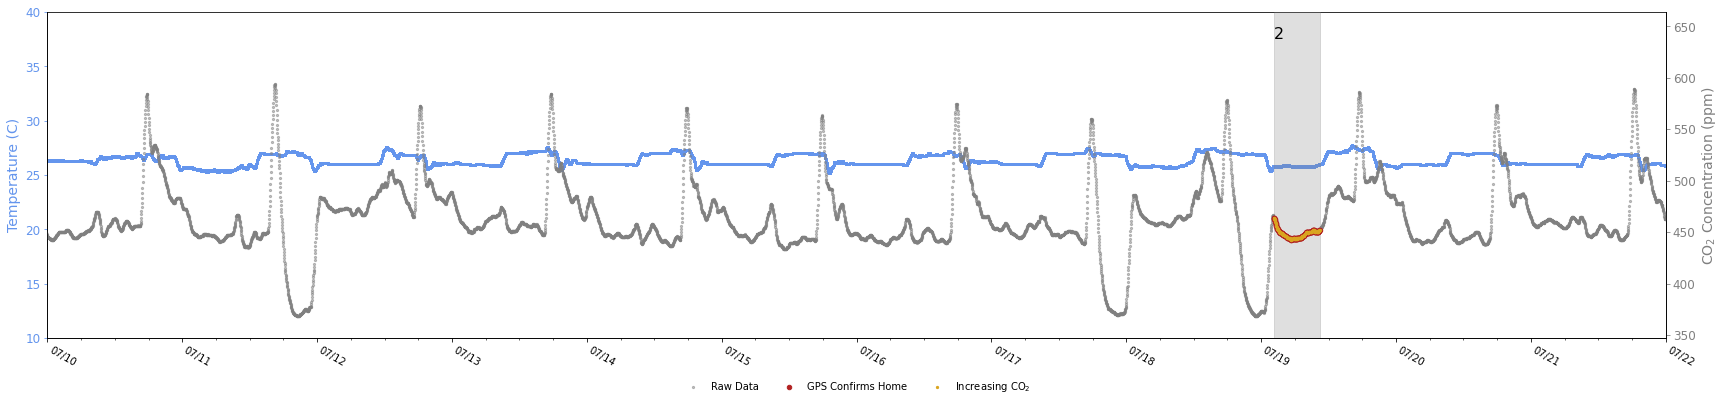

In [29]:
hx.plot_overlap(time_period=[datetime(2020,7,10),datetime(2020,7,22)])

In [30]:
bad_nights["hxj6brwj"] = hx.s.values

<div class="alert-block alert alert-danger">
    
After a closer look, we might not want to include data from this participant at all. There are recurrent spikes in `co2` at around 18:00 every day which makes me think the concentration spikes when they get home for the day so the beacon would be in the living room. The new night that we were able to get has GPS data confirming they are _not_ home so we shouldn't even include that data point.

</div>

### i31pt4b4

In [31]:
i3 = co2_inspection("i31pt4b4")

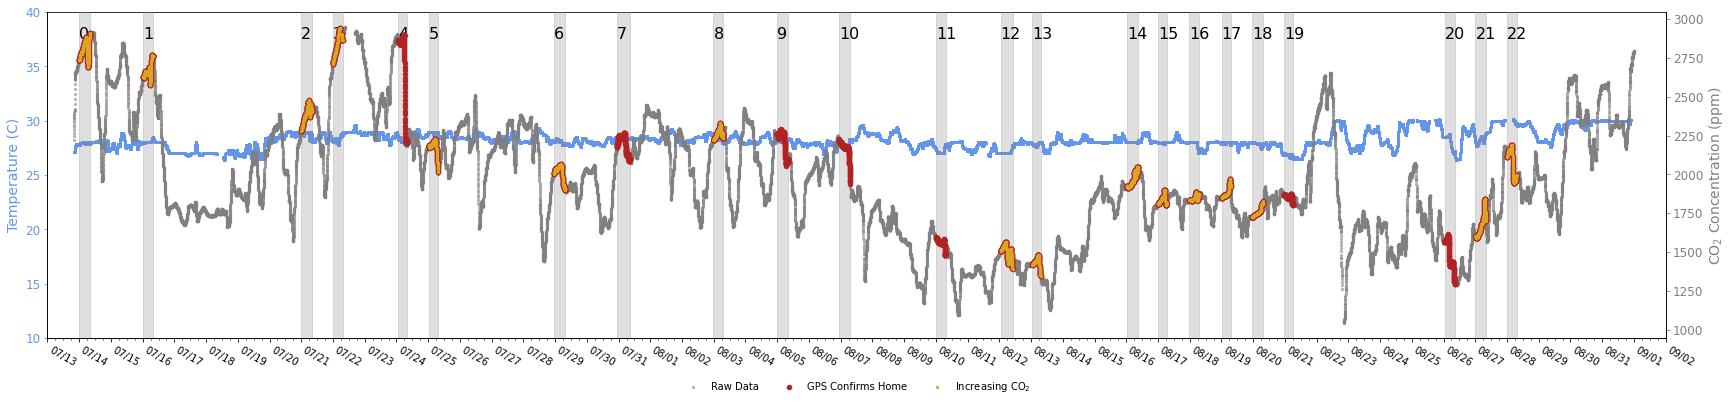

In [32]:
i3.plot_overlap(time_period=[datetime(2020,7,13),datetime(2020,9,2)])

<div class="alert-block alert alert-success">
    
These data look decent

</div>

### i4w8dx6l

In [33]:
i4 = co2_inspection(pt="i4w8dx6l")

Locator attempting to generate 8299 ticks ([10580.0, ..., 18878.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8299 ticks ([10580.0, ..., 18878.0]), which exceeds Locator.MAXTICKS (1000).


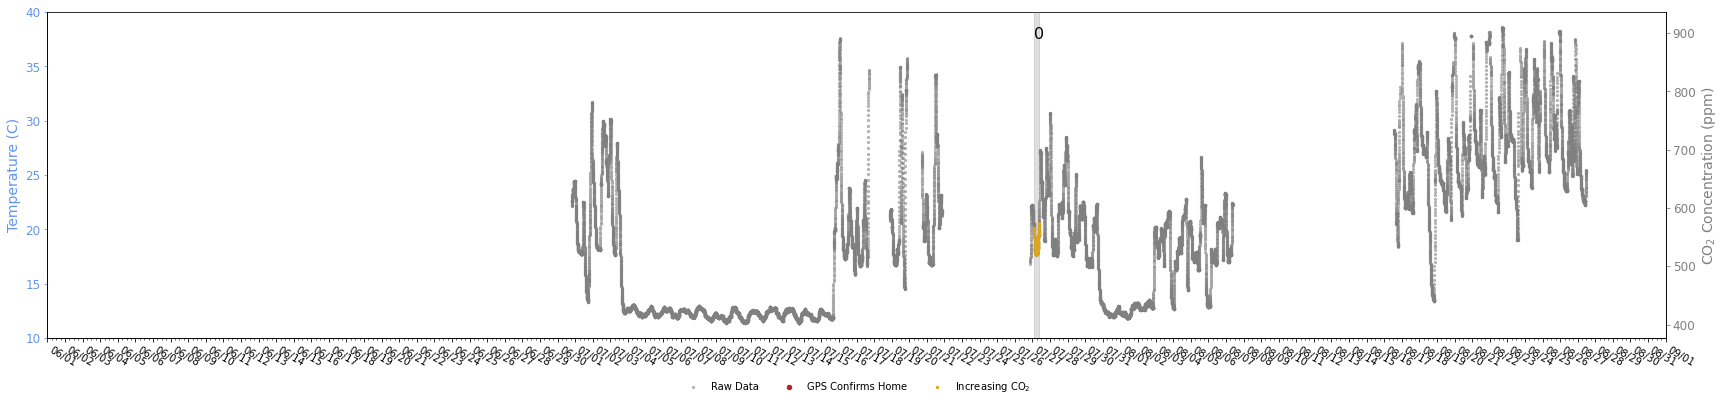

In [34]:
i4.plot_overlap(time_period=[datetime(2020,6,1),datetime(2020,9,1)])

Locator attempting to generate 8299 ticks ([10580.0, ..., 18878.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8299 ticks ([10580.0, ..., 18878.0]), which exceeds Locator.MAXTICKS (1000).


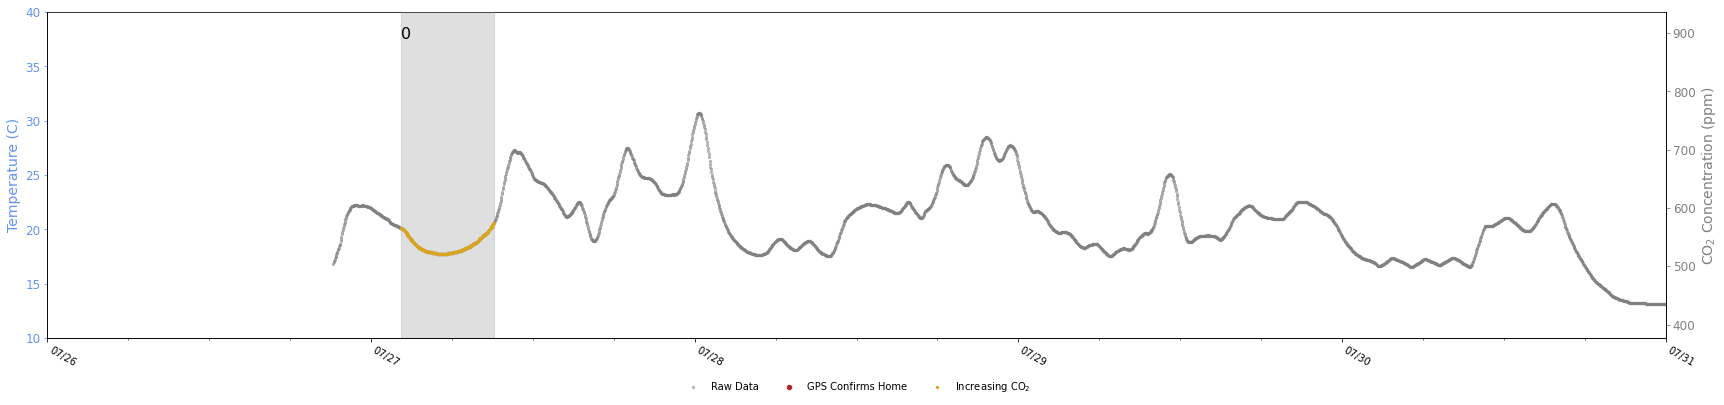

In [35]:
i4.plot_overlap(time_period=[datetime(2020,7,26),datetime(2020,7,31)])

In [36]:
bad_nights["i4w8dx6l"] = i4.s.values

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon, and there are no GPS data.

</div>

### idbkjh8u

In [37]:
ib = co2_inspection(pt="idbkjh8u")

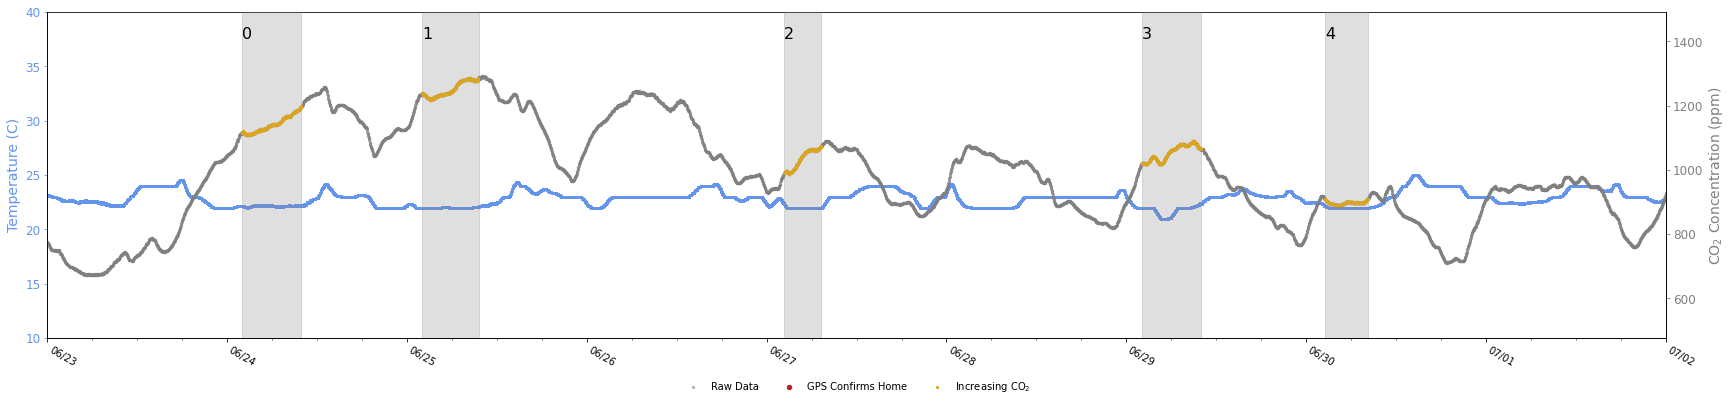

In [38]:
ib.plot_overlap(time_period=[datetime(2020,6,23),datetime(2020,7,2)])

<div class="alert-block alert alert-success">
    
Looks like we got two more nights of data!

</div>

### itmylz3g

In [39]:
it = co2_inspection("itmylz3g")

Locator attempting to generate 8304 ticks ([10580.0, ..., 18883.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8304 ticks ([10580.0, ..., 18883.0]), which exceeds Locator.MAXTICKS (1000).


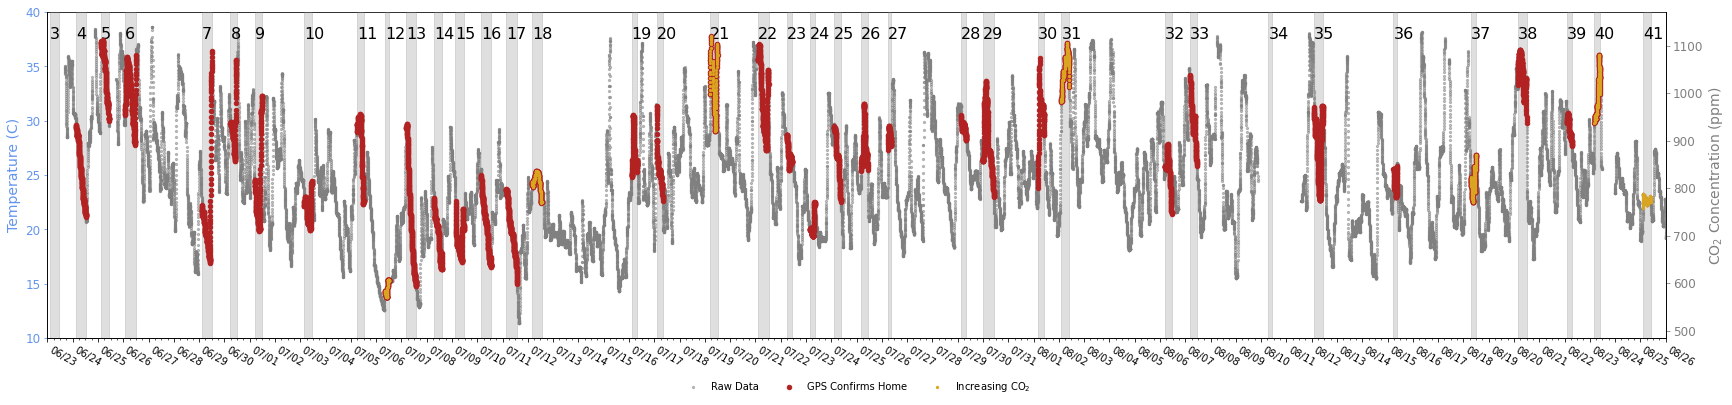

In [40]:
it.plot_overlap(time_period=[datetime(2020,6,23),datetime(2020,8,26)])

In [41]:
bad_nights["itmylz3g"] = it.s.iloc[[4,5,12,13,14,16,17,25,28,32,33]].values

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon.

</div>

### kyj367pi

In [42]:
ky = co2_inspection("kyj367pi")

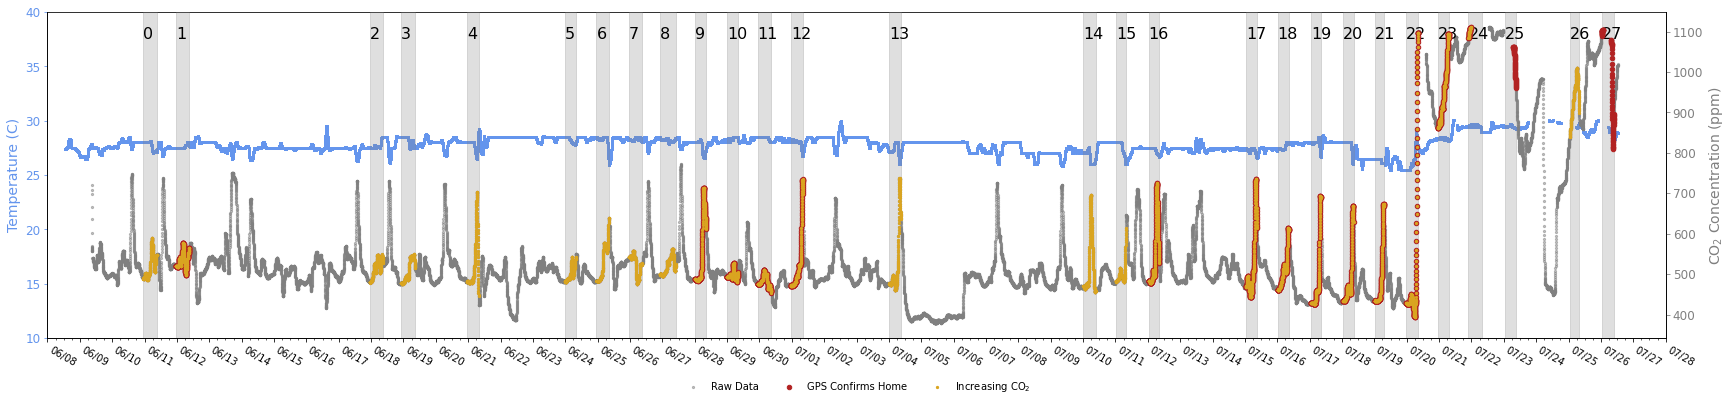

In [43]:
ky.plot_overlap(time_period=[datetime(2020,6,8),datetime(2020,7,28)])

In [44]:
bad_nights["kyj367pi"] = ky.s.iloc[[25,27]].values

<div class="alert-block alert alert-warning">
    
It looks like we got a few more nights, but pretty troubling results. Again it seems like the beacon might not be in the bedroom.
    
</div>

### lkkjddam

In [45]:
lk = co2_inspection("lkkjddam")

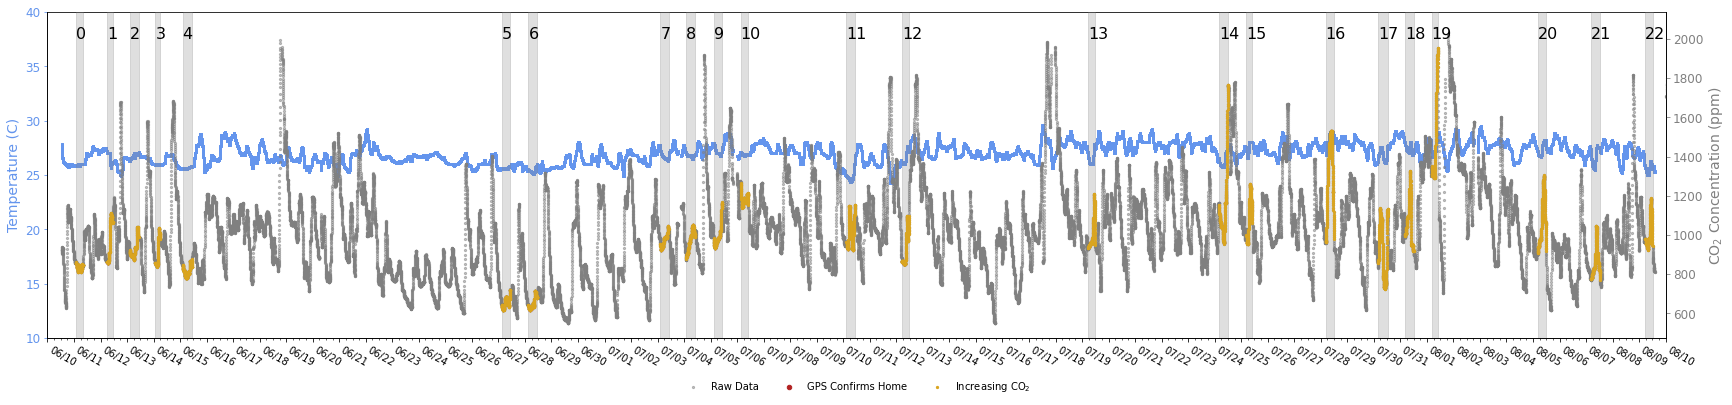

In [46]:
lk.plot_overlap(time_period=[datetime(2020,6,10),datetime(2020,8,10)])

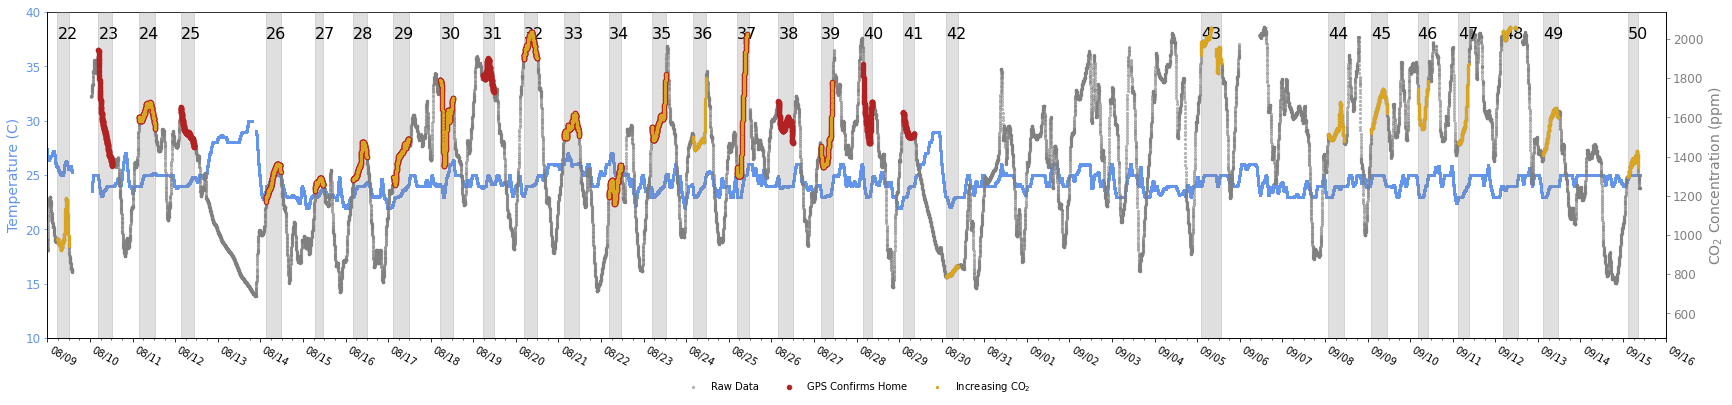

In [47]:
lk.plot_overlap(time_period=[datetime(2020,8,9),datetime(2020,9,16)])

<div class="alert-block alert alert-success">
    
Data look good - use night **40** as a night to _include_ for analysis based on the temperature and concentration shifts.

</div>

### nvtfpaor

In [48]:
nv = co2_inspection("nvtfpaor")

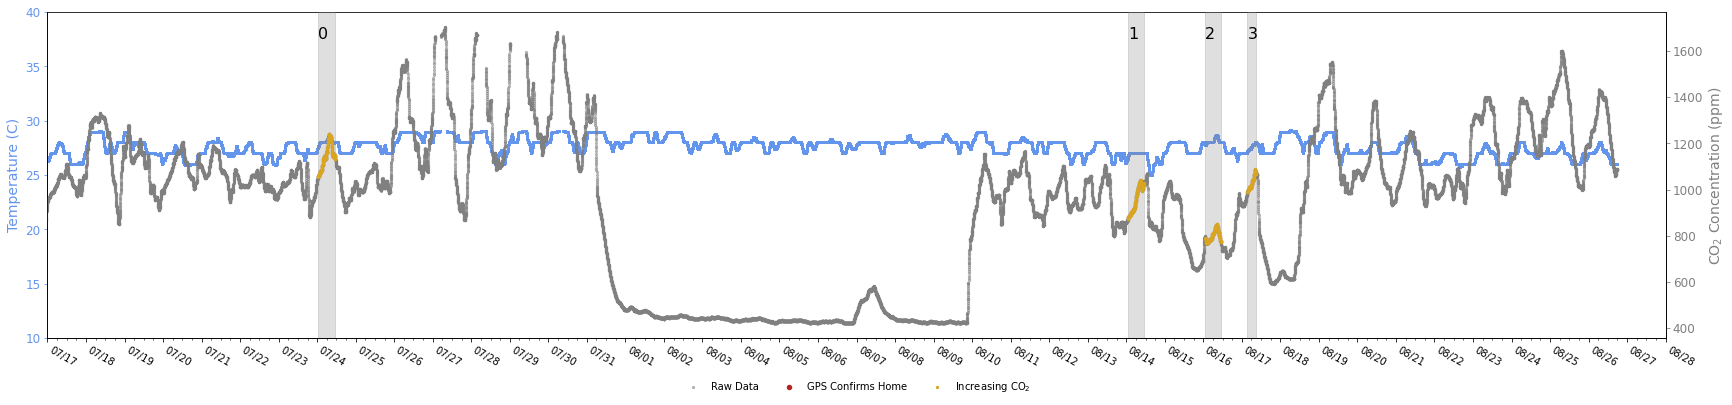

In [49]:
nv.plot_overlap(time_period=[datetime(2020,7,17),datetime(2020,8,28)])

<div class="alert-block alert alert-success">
    
More nights!

</div>

### olaxadz5

In [50]:
ox = co2_inspection("olaxadz5")

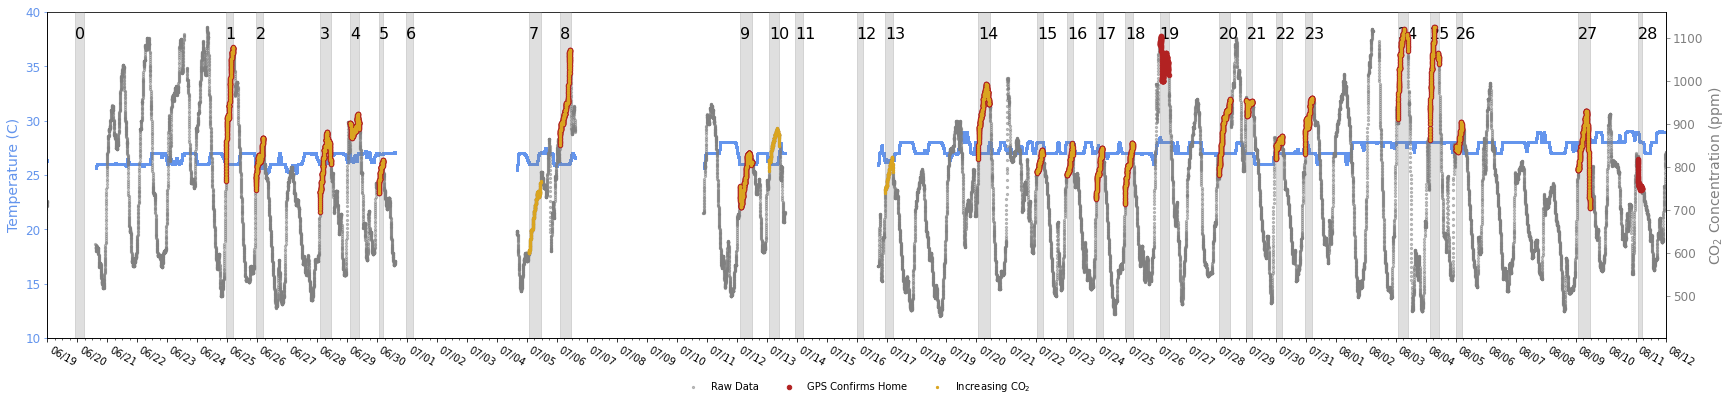

In [51]:
ox.plot_overlap(time_period=[datetime(2020,6,19),datetime(2020,8,12)])

<div class="alert-block alert alert-success">
    
We get to include more nights!
    
</div>

### qh34m4r9

In [52]:
qh = co2_inspection("qh34m4r9")

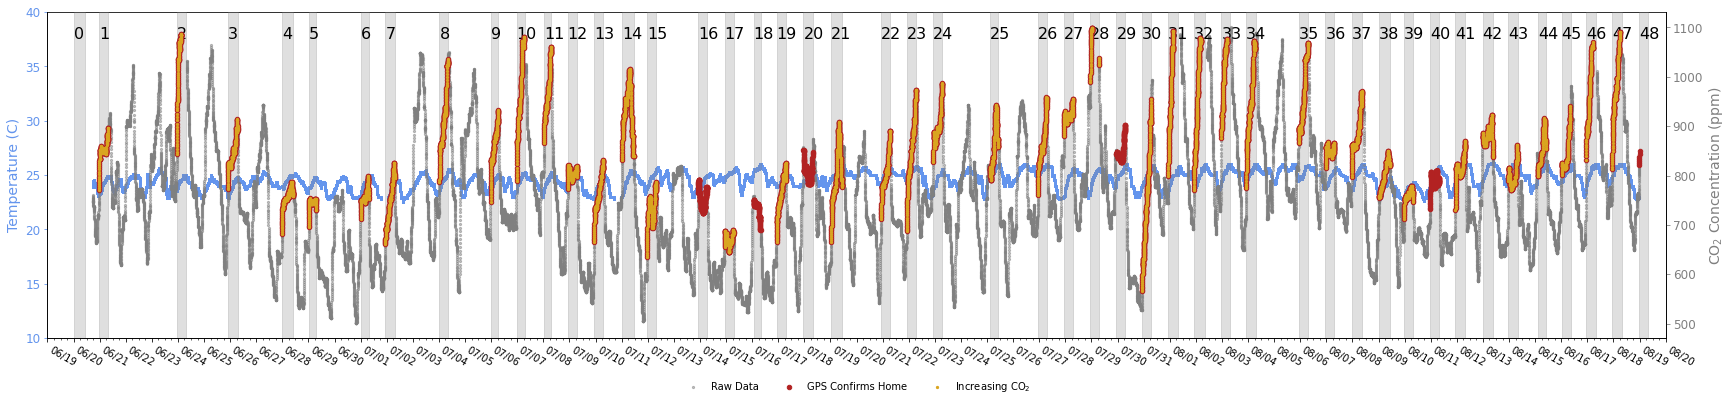

In [53]:
qh.plot_overlap(time_period=[datetime(2020,6,19),datetime(2020,8,20)])

<div class="alert-block alert alert-success">
    
A _really_ good participant and the new method seems to capture even _more_ nights of data that do seem to correspond to the Fitbit data and even the GPS data. Not sure why the `gps` filter was not able to pick up on them although there does seem to be some odd scatter.
    
</div>

### rnse61g4

In [54]:
rn = co2_inspection("rnse61g4")

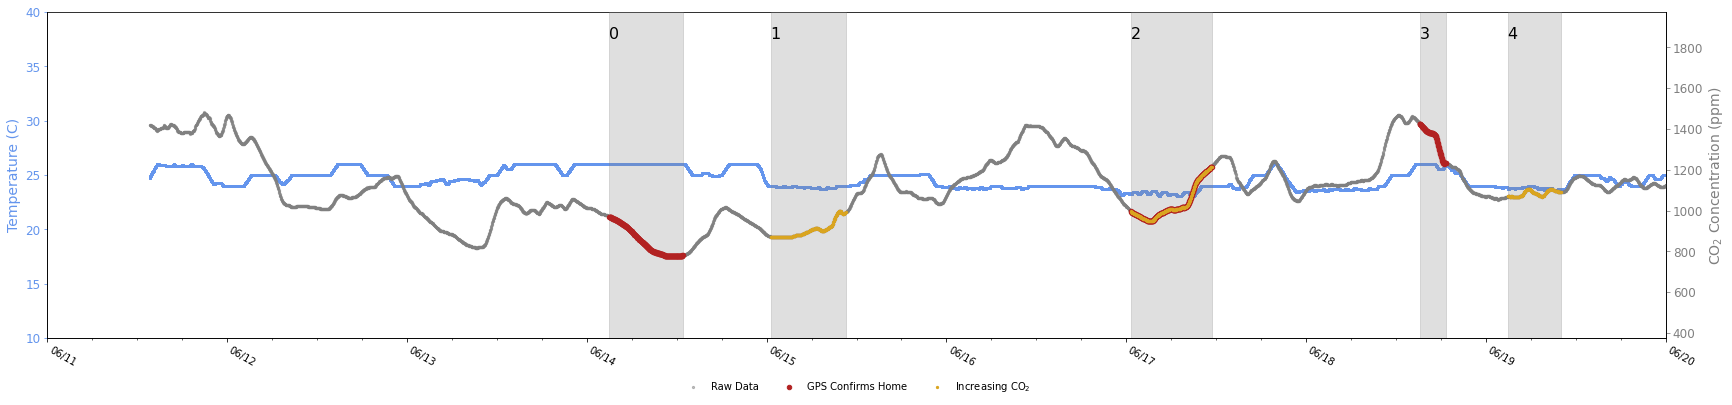

In [55]:
rn.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,6,20)])

<div class="alert-block alert alert-warning">
    
The increasing nights make a lot sense, but not the gps but it is possible the AC is keeping concentrations low.

</div>

### tlmlq19s

In [56]:
tl = co2_inspection("tlmlq19s")

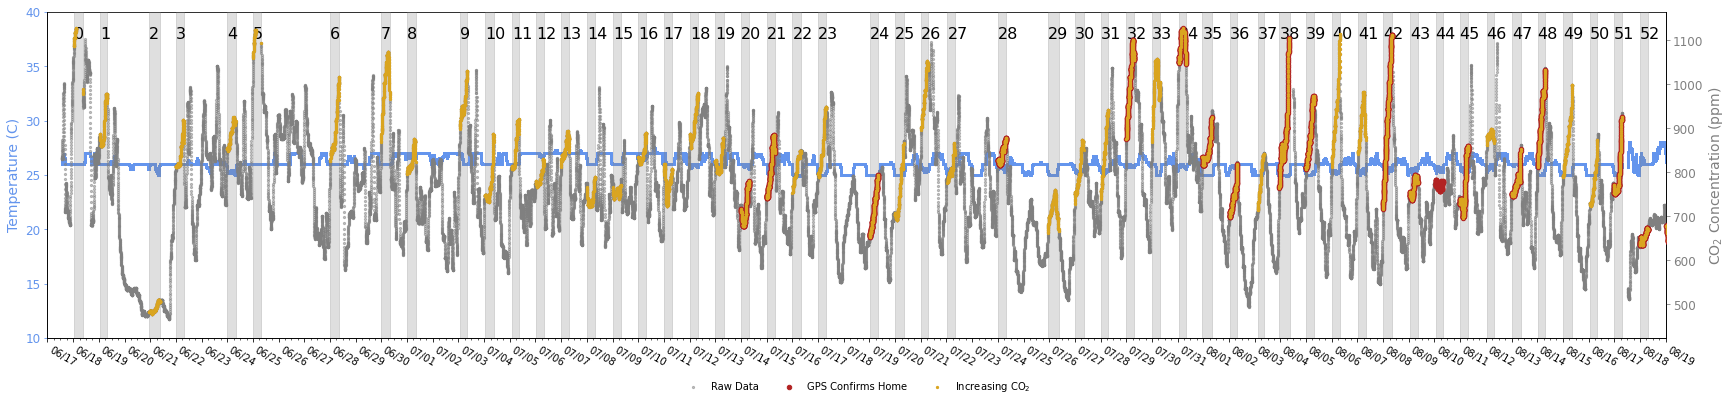

In [57]:
tl.plot_overlap(time_period=[datetime(2020,6,17),datetime(2020,8,19)])

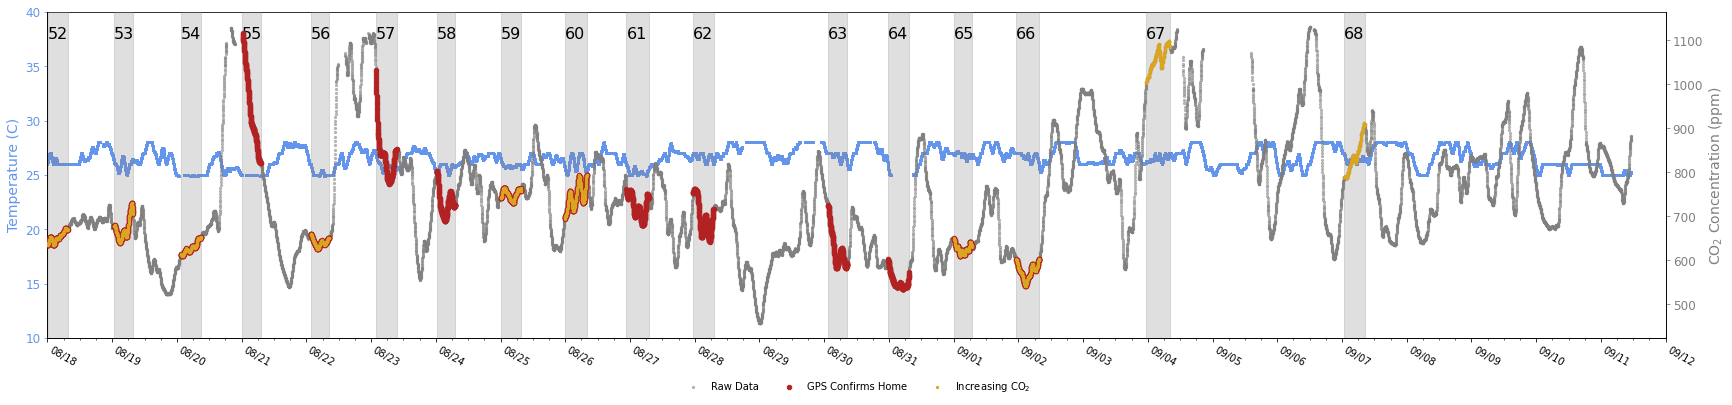

In [58]:
tl.plot_overlap(time_period=[datetime(2020,8,18),datetime(2020,9,12)])

In [59]:
bad_nights["tlmlq19s"] = tl.s.iloc[[2,55,57]]

<div class="alert-block alert alert-warning">
    
Some odd nights
    
</div>

### tmexej5v

In [60]:
tm = co2_inspection("tmexej5v")

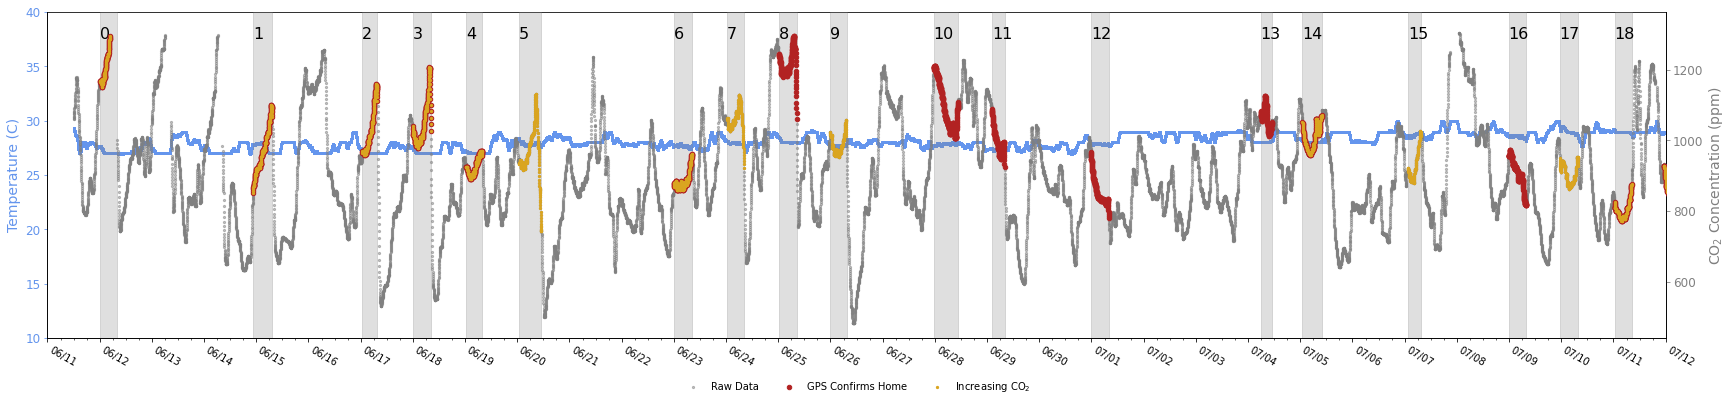

In [61]:
tm.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,7,12)])

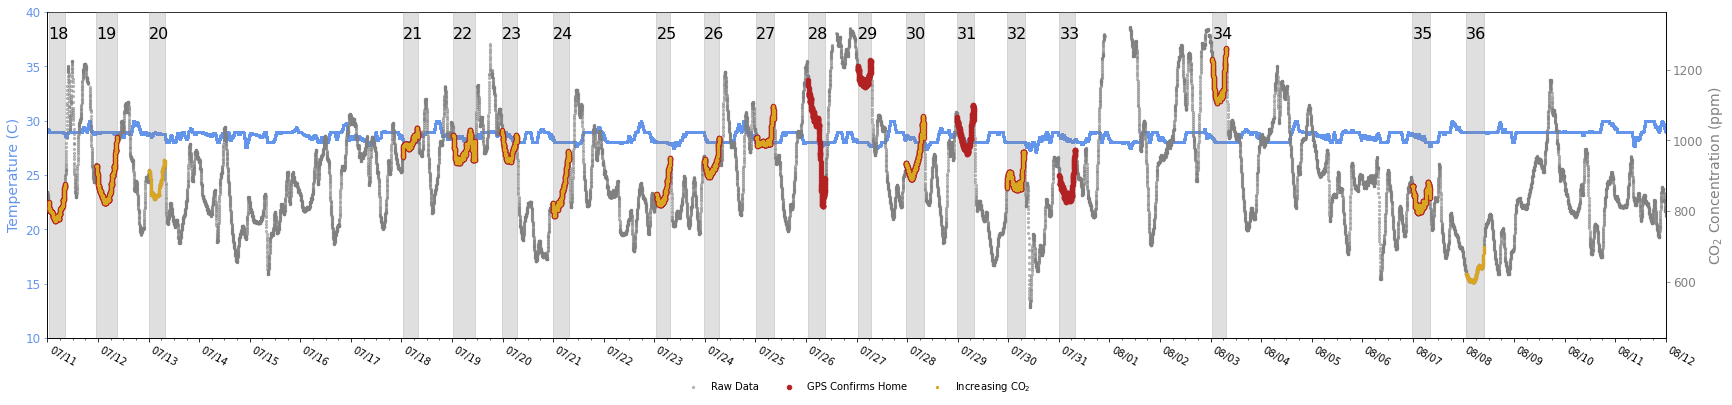

In [62]:
tm.plot_overlap(time_period=[datetime(2020,7,11),datetime(2020,8,12)])

<div class="alert-block alert alert-warning">
    
Some of these nights make no sense.
    
</div>

### vr9j5rry

In [63]:
vr = co2_inspection("vr9j5rry")

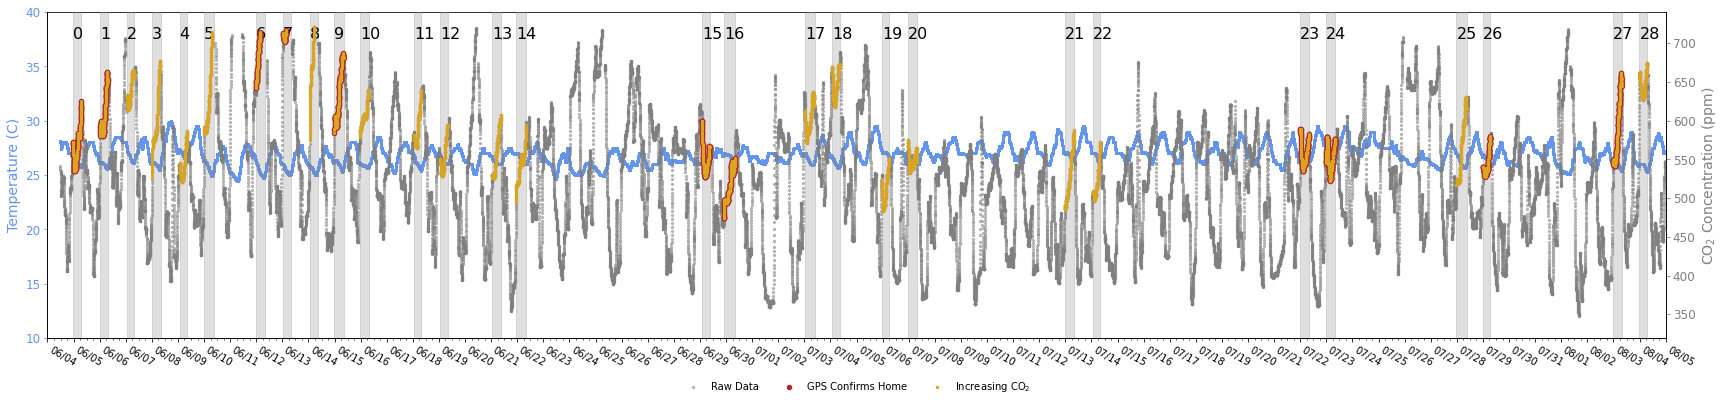

In [64]:
vr.plot_overlap(time_period=[datetime(2020,6,4),datetime(2020,8,5)])

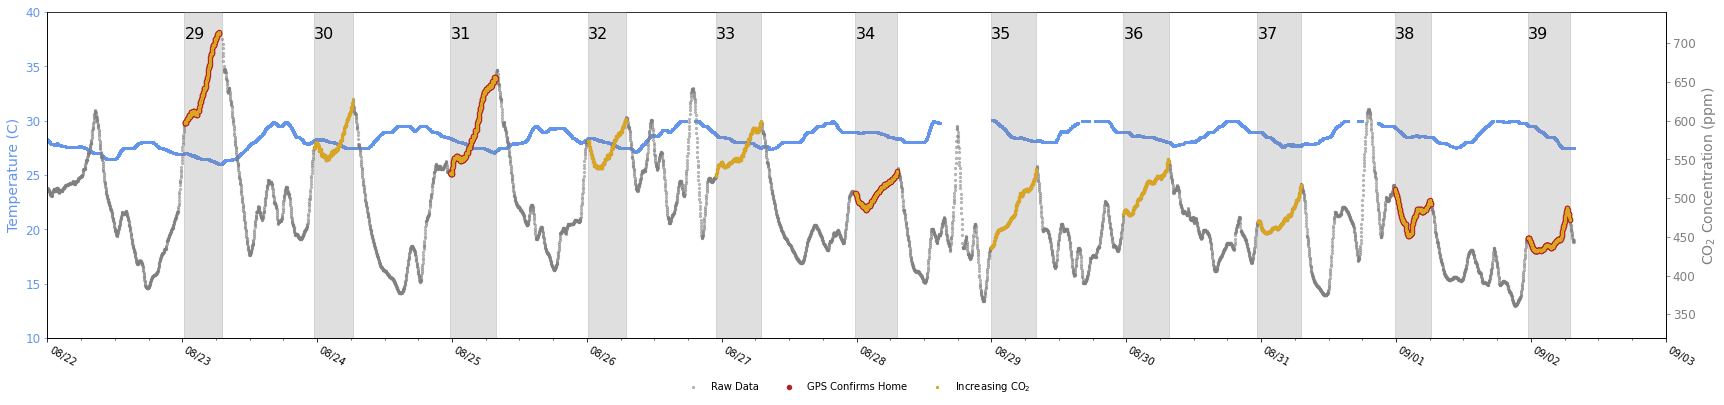

In [65]:
vr.plot_overlap(time_period=[datetime(2020,8,22),datetime(2020,9,3)])

<div class="alert-block alert alert-success">
    
Data look good and looks like we get more nights!
    
</div>

### xdbdrk6e

In [66]:
xd = co2_inspection("xdbdrk6e")

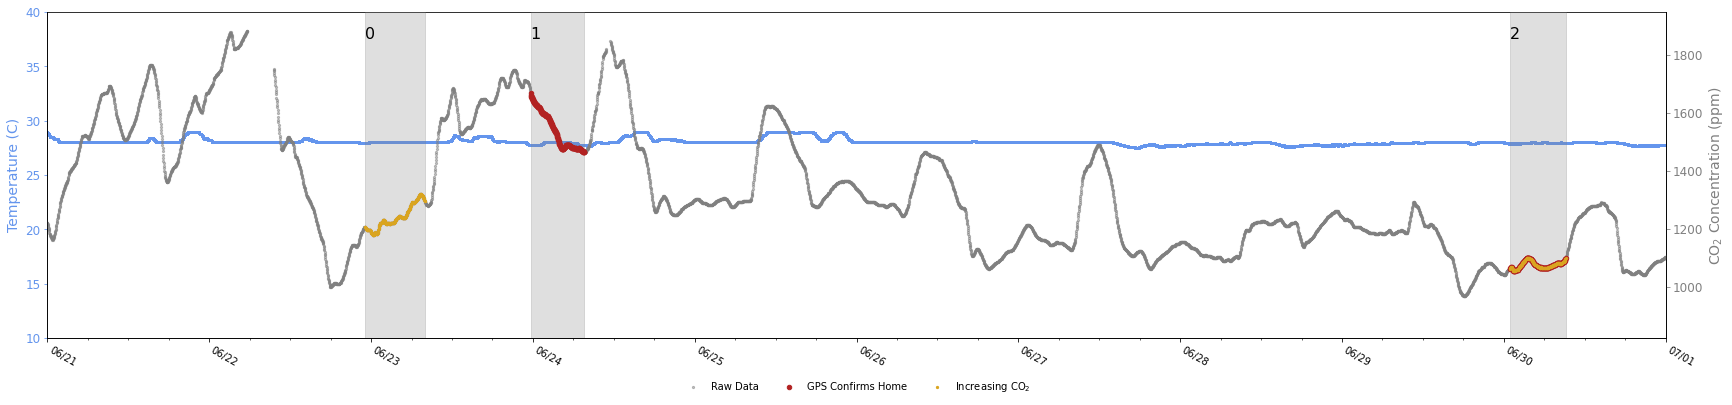

In [67]:
xd.plot_overlap(time_period=[datetime(2020,6,21),datetime(2020,7,1)])

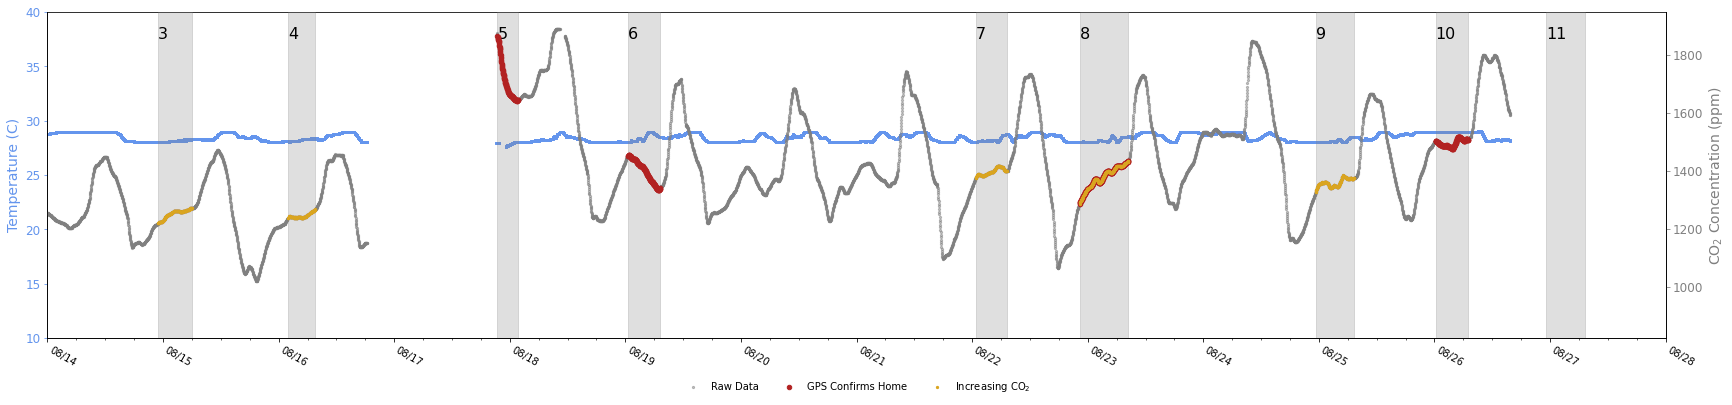

In [68]:
xd.plot_overlap(time_period=[datetime(2020,8,14),datetime(2020,8,28)])

<div class="alert-block alert alert-warning">
    
Looks like another living room beacon.

</div>

### xlw5ntd5

In [69]:
xl = co2_inspection("xlw5ntd5")

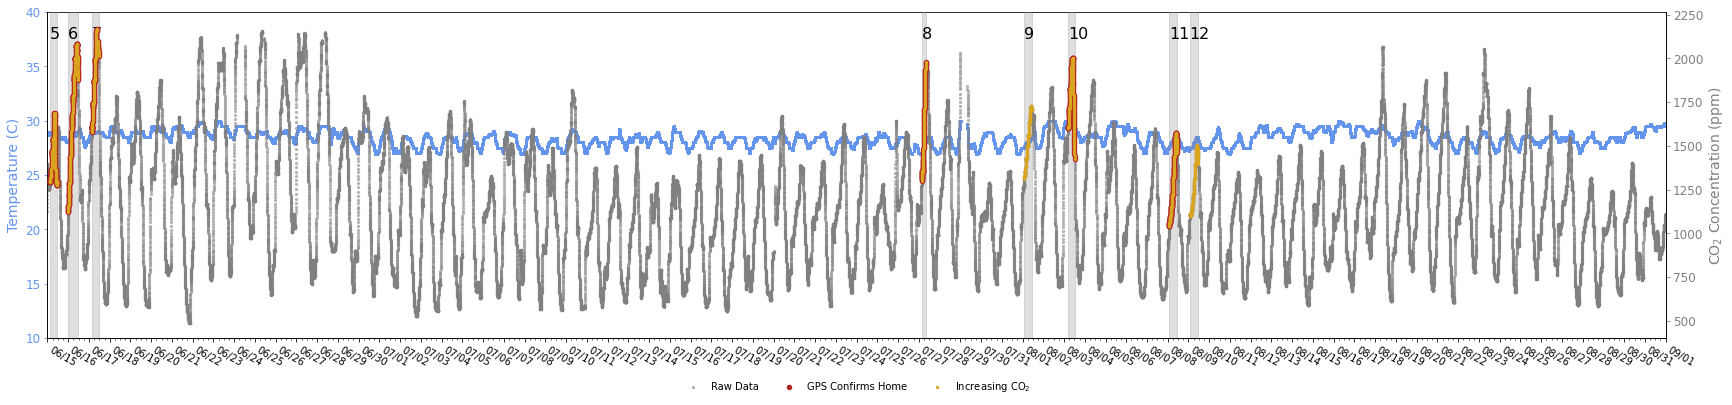

In [70]:
xl.plot_overlap(time_period=[datetime(2020,6,15),datetime(2020,9,1)])

<div class="alert-block alert alert-success">
    
There do not appear to be any issues with the model for this participant and we were able to recover 2 more nights of data.

</div>

## Test Case: Participant zdpffrox

In [71]:
zd = co2_inspection("zdpffrox")

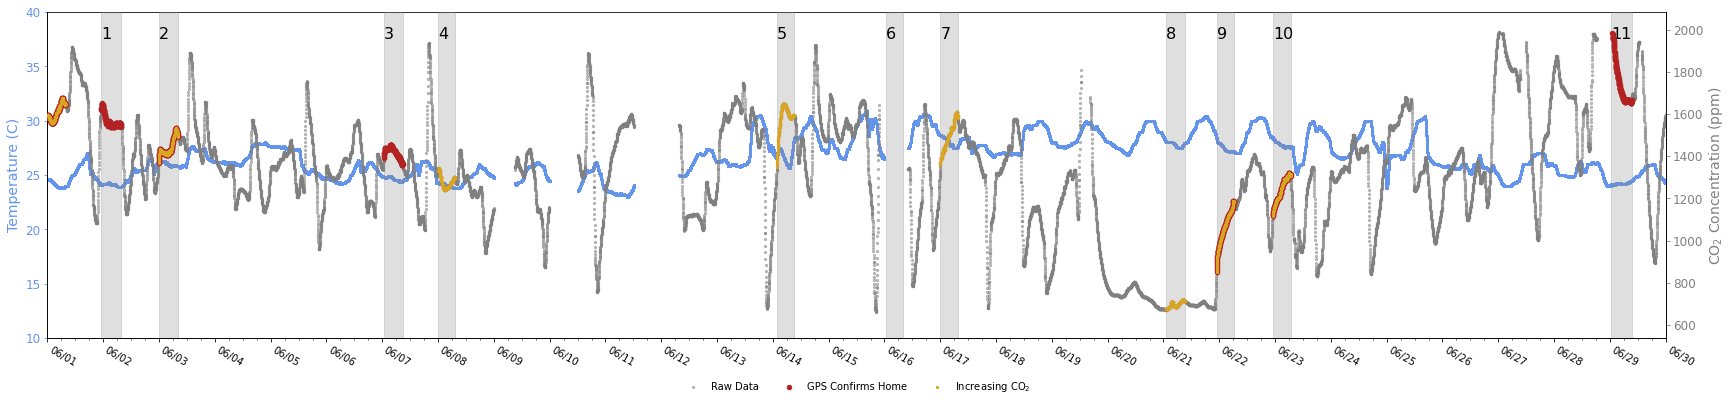

In [72]:
zd.plot_overlap(time_period=[datetime(2020,6,1),datetime(2020,6,30)])

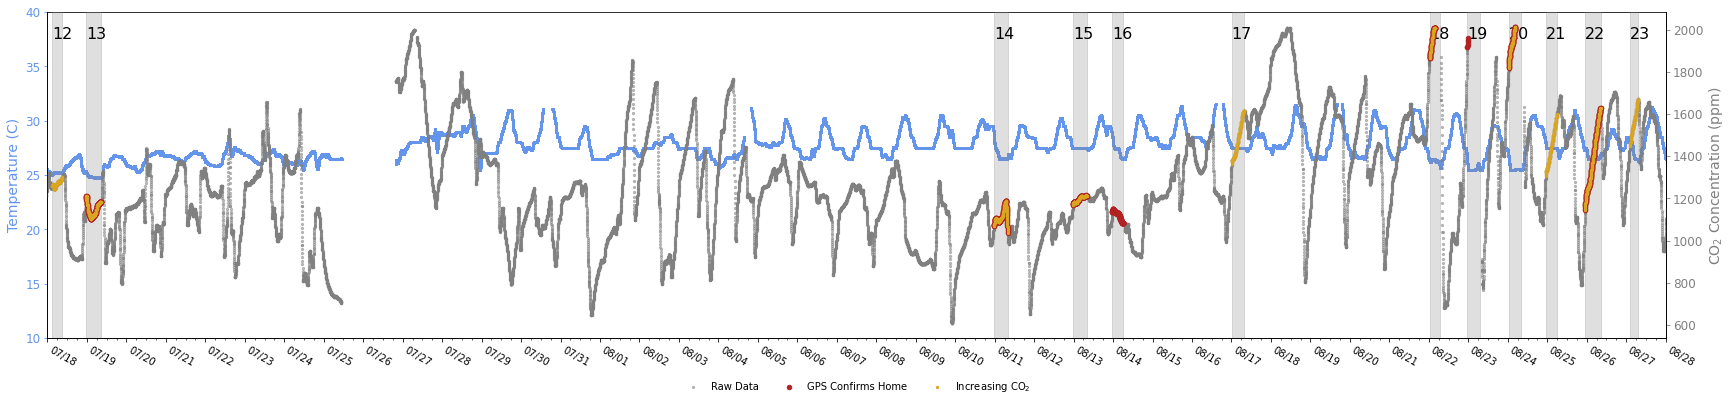

In [73]:
zd.plot_overlap(time_period=[datetime(2020,7,18),datetime(2020,8,28)])

In [74]:
bad_nights["zdpffrox"] = zd.s.iloc[[8]].values

<div class="alert-block alert alert-success">
    
Seems like it is working even on a crazy dataset like this.

</div>

## Conclusion
After closer inspection, only the following participants should be considered:

| | Beiwe | Beacon |
| :-- | :-: | :-: |
| 1 | kyj367pi | 1 |
| 2 | xlw5ntd5 | 10 |
| 3 | qh34m4r9 | 19 |
| 4 | zdpffrox | 7 |
| 5 | 9jtzsuu8 | 15 |
| 6 | e73a1pd5 | 16 |
| 7 | i31pt4b4 | 11 |
| 8 | idbkjh8u | 30 |
| 9 | tlmlq19s | 36 |
| 10 | vr9j5rry | 25 |
| 11 | lkkjddam | 21 |
| 12 | nvtfpaor | 46 |
| 13 | olaxadz5 | 38 |
| 14 | rnse61g4 | 34 |
| 15 | tmexej5v | 29 |

In [75]:
bad_nights_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in bad_nights.items() ]))
#bad_nights_df.to_csv("../data/interim/bad_analysis_nights.csv")

## Methods Figure
We want to include a figure that highlights this process in the methods section of the IAQ and SQ paper. The following cells do so.

In [76]:
def plot_overlap(pt, raw_in, filtered_in, save=False, **kwargs):
    """"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    fig, t_ax = plt.subplots(figsize=(10,6))
    raw = raw_in[raw_in["beiwe"] == pt]
    filtered = filtered_in[filtered_in["beiwe"] == pt]
    # temperature axis
    try:
        t_ax.plot(raw["timestamp"],raw["temperature_c"],linewidth=2,color="firebrick")
    except AttributeError:
        print("no temperature data")
    plt.xticks(rotation=0,ha="center",fontsize=tick_fs)
    ## y-axis
    t_ax.set_ylim([21.5,30])
    t_ax.set_ylabel("Temperature (C)",fontsize=label_fs)
    t_ax.yaxis.label.set_color('firebrick')
    t_ax.tick_params(axis='y', colors='firebrick',labelsize=tick_fs) 
    # co2 axis
    ax = t_ax.twinx()
    ## sleep events
    if "time_period" in kwargs.keys():
        starting = kwargs["time_period"][0]
        ending = kwargs["time_period"][1]
    else:
        starting = datetime(1900,1,1)
        ending = datetime(2021,1,1)
    for s, e in zip(filtered["start_time"].unique(),filtered["end_time"].unique()):
        if pd.to_datetime(s) > starting and pd.to_datetime(e) < ending:
            ax.axvspan(pd.to_datetime(s),pd.to_datetime(e),color="grey",alpha=0.25,zorder=1)
            ax.text(pd.to_datetime(s) + (pd.to_datetime(e) - pd.to_datetime(s))/2,np.nanmax(filtered["co2"]),"Participant Asleep",ha="center",va="top", fontsize=label_fs)
    ## beacon data
    ax.plot(raw["timestamp"],raw["co2"],color="black",alpha=1,linewidth=2,zorder=2) # raw
    ## x-axis
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    if "time_period" in kwargs.keys():
        ax.set_xlim([kwargs["time_period"][0],kwargs["time_period"][1]])
    # y-axis
    ax.set_ylabel("CO$_2$ Concentration (ppm)",fontsize=label_fs,labelpad=30,rotation=-90)
    ax.set_ylim([550,2200])
    ax.set_yticks(range(600,2400,400))
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='y',colors="black", labelsize=tick_fs) 
    
    if save:
        plt.savefig(f"../reports/figures/beacon_summary/co2_t-during_sleep-{pt}-{e}.pdf",bbox_inches="tight")

    plt.show()
    plt.close()

### Exemplary Figures
We have two nights to show:
1. `co2` decreasing but we still include - Participant lkkjddam, Night 40 (08/28)
2. `co2` deacreaing but we do not include - Participant 9jtzsuu8, Night 19 (07/24)

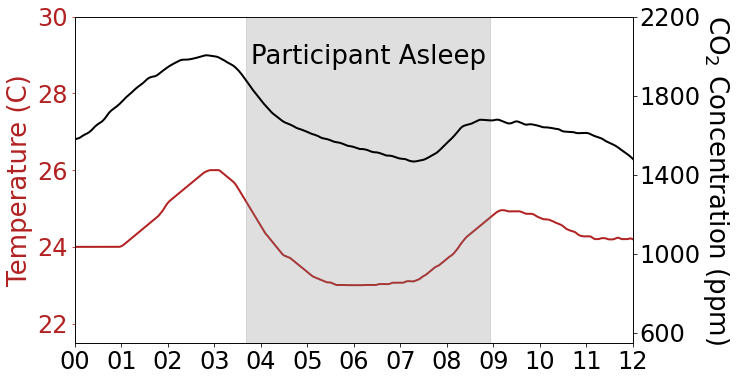

In [77]:
plot_overlap("lkkjddam", beacon, beacon_filtered, time_period=[datetime(2020,8,28),datetime(2020,8,28,12)], save=False)

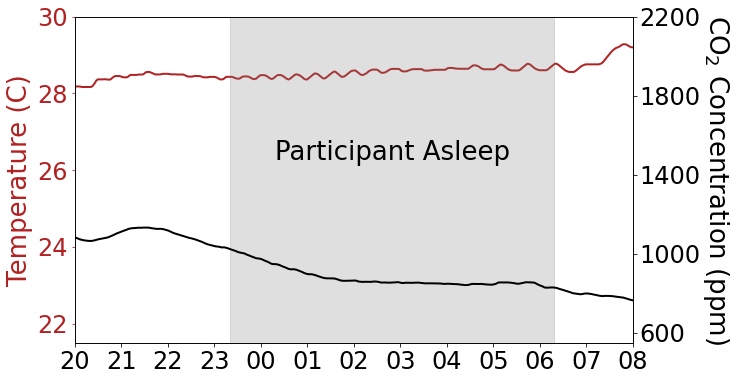

In [78]:
plot_overlap("9jtzsuu8", beacon, beacon_filtered, time_period=[datetime(2020,7,23,20),datetime(2020,7,24,8)], save=False)

## Method Summary
We can look at how many nights we recover from using `co2` for occupancy detection.

In [126]:
co2_based_nights = pd.read_csv("../data/processed/beacon-fb_co2_and_gps_filtered_summary-ux_s20.csv")
co2_based_nights = co2_based_nights[['start_time','beacon','beiwe','tvoc_mean','co_mean', 'co2_mean', 'pm2p5_mass_mean', 'temperature_c_mean', 'rh_mean']].dropna(subset=['tvoc_mean', 'co_mean', 'co2_mean', 'pm2p5_mass_mean', 'temperature_c_mean', 'rh_mean'],how="all")
print("Number of nights:",len(co2_based_nights))

Number of nights: 453


In [133]:
co2_based_nights["beiwe"].value_counts()

tlmlq19s    54
qh34m4r9    48
itmylz3g    36
tmexej5v    36
vr9j5rry    35
awa8uces    28
lkkjddam    27
4i7679py    25
olaxadz5    25
9jtzsuu8    24
i31pt4b4    23
zdpffrox    20
kyj367pi    19
xlw5ntd5    13
9xmhtq74    10
xdbdrk6e    10
745vq78e     5
rnse61g4     5
idbkjh8u     3
e73a1pd5     3
hxj6brwj     2
nvtfpaor     2
Name: beiwe, dtype: int64

In [128]:
co2_based_nights[co2_based_nights["beiwe"] == "tlmlq19s"]

start_time  beacon     beiwe   tvoc_mean   co_mean     co2_mean  \
817  2020-06-18 00:41:30     NaN  tlmlq19s  391.525428  5.061054  1110.343881   
818  2020-06-22 00:03:00     NaN  tlmlq19s  361.024229  3.475597   845.747315   
819  2020-06-23 23:56:30     NaN  tlmlq19s  414.784758  4.196660   889.282515   
820  2020-06-25 00:08:30     NaN  tlmlq19s  519.941921  3.635531  1104.003947   
821  2020-06-28 00:21:00     NaN  tlmlq19s  410.920866  3.750340   902.618910   
822  2020-06-29 23:51:30     NaN  tlmlq19s  481.794421  3.332777  1003.853153   
823  2020-07-01 00:08:30     NaN  tlmlq19s  269.209156  2.601174   828.943009   
824  2020-07-03 01:22:30     NaN  tlmlq19s  371.825397  3.357671   957.618407   
825  2020-07-05 01:54:30     NaN  tlmlq19s  487.443886  3.517899   855.843538   
826  2020-07-12 00:13:00     NaN  tlmlq19s  461.741847  3.772271   910.398365   
827  2020-07-14 00:12:30     NaN  tlmlq19s  251.691270  3.444134   717.276261   
828  2020-07-15 00:01:00     NaN  tlmlq19s  305.501214  3.790781   808.808925   
829  2020-07-16 00:07:30     NaN  tlmlq19s  312.250072  4.186688   808.361731   
830  2020-07-17 00:07:00     NaN  tlmlq19s  364.948018  3.984842   856.990603   
831  2020-07-19 00:21:30     NaN  tlmlq19s  268.703502  3.720264   714.986328   
832  2020-07-19 23:51:30     NaN  tlmlq19s  221.835802  3.881471   751.441253   
833  2020-07-21 00:26:30     NaN  tlmlq19s  425.583168  3.936985   982.725754   
834  2020-07-24 00:13:00     NaN  tlmlq19s  426.861661  3.884266   842.097193   
835  2020-07-26 23:45:00     NaN  tlmlq19s  355.132400  3.573935   801.244474   
836  2020-07-28 00:10:30     NaN  tlmlq19s  292.989052  3.385274   844.318380   
837  2020-07-29 00:13:00     NaN  tlmlq19s  378.960883  3.612931  1007.055045   
838  2020-07-31 01:00:30     NaN  tlmlq19s  406.595107  3.630206  1093.509126   
839  2020-07-31 23:13:30     NaN  tlmlq19s  317.150109  3.998474   844.670363   
840  2020-08-02 00:30:30     NaN  tlmlq19s  467.354640  3.486886   740.548948   
841  2020-08-03 02:47:00     NaN  tlmlq19s  329.458960  3.846844   783.361197   
842  2020-08-03 23:06:00     NaN  tlmlq19s  463.269688  3.755029   880.647284   
843  2020-08-04 23:59:00     NaN  tlmlq19s  356.076324  3.703972   889.317795   
844  2020-08-06 00:08:00     NaN  tlmlq19s  405.881077  3.745460   934.146184   
845  2020-08-07 00:38:00     NaN  tlmlq19s  378.838389  3.820007   916.715594   
846  2020-08-08 00:02:00     NaN  tlmlq19s  322.659247  3.547788   922.849154   
847  2020-08-09 00:57:30     NaN  tlmlq19s  252.485354  3.326609   766.934936   
848  2020-08-10 01:00:00     NaN  tlmlq19s  247.541736  3.327096   771.225872   
849  2020-08-10 23:29:00     NaN  tlmlq19s  197.990348  3.212549   765.027280   
850  2020-08-13 00:27:00     NaN  tlmlq19s  389.061611  3.373230   771.146396   
851  2020-08-14 00:23:30     NaN  tlmlq19s  245.960346  3.577829   923.608611   
852  2020-08-15 00:08:00     NaN  tlmlq19s  276.615058  3.860184   874.781215   
853  2020-08-16 01:29:30     NaN  tlmlq19s  178.685458  3.569887   774.017634   
854  2020-08-16 23:30:00     NaN  tlmlq19s  318.486049  3.637113   790.496300   
855  2020-08-18 00:07:30     NaN  tlmlq19s  135.210820  2.951344   653.649623   
856  2020-08-19 00:43:00     NaN  tlmlq19s   79.238114  2.889187   673.892754   
857  2020-08-20 01:25:30     NaN  tlmlq19s   50.543346  2.683817   628.924674   
858  2020-08-21 00:07:30     NaN  tlmlq19s  140.645767  2.773109   941.041334   
859  2020-08-22 01:34:30     NaN  tlmlq19s  223.297561  3.510157   640.423738   
860  2020-08-23 01:41:00     NaN  tlmlq19s  218.704433  3.165731   836.641254   
861  2020-08-24 00:25:00     NaN  tlmlq19s  241.275474  3.282342   728.930912   
862  2020-08-25 00:06:00     NaN  tlmlq19s  218.611477  3.294803   750.574564   
863  2020-08-25 23:46:30     NaN  tlmlq19s  234.445278  2.956093   744.106159   
864  2020-08-26 22:42:00     NaN  tlmlq19s  358.930444  3.271975   722.104513   
865  2020-08-27 23:22:30     NaN  tlmlq19s  2

In [110]:
gps_based_nights = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv")
gps_based_nights = gps_based_nights[['start_time','beacon','beiwe','tvoc_mean', 'co_mean', 'co2_mean', 'pm2p5_mass_mean', 'temperature_c_mean', 'rh_mean']].dropna(subset=['tvoc_mean', 'co_mean', 'co2_mean', 'pm2p5_mass_mean', 'temperature_c_mean', 'rh_mean'],how="all")
print("Number of nights:",len(gps_based_nights))

Number of nights: 372


In [111]:
len(co2_based_nights) - len(gps_based_nights)

81

A deeper look into the nights we recover using `co2`

In [122]:
merged = co2_based_nights.merge(right=gps_based_nights,on=["beacon","beiwe","start_time"],how="outer",indicator=True)
only_co2 = merged[merged["_merge"] == "left_only"]
only_gps = merged[merged["_merge"] == "right_only"]
print("Number of nights", len(only_co2), "from", len(only_co2["beiwe"].unique()), "participants")
print("Beiwe\tCO2 N\tGPS N")
print(only_co2["beiwe"].value_counts().sort_index())
print(merged["beiwe"].value_counts().sort_index())

Number of nights 81 from 14 participants
Beiwe	CO2 N	GPS N
745vq78e     4
9xmhtq74     2
hxj6brwj     1
idbkjh8u     3
kyj367pi     3
lkkjddam     9
nvtfpaor     2
olaxadz5     3
rnse61g4     2
tlmlq19s    22
vr9j5rry    19
xdbdrk6e     4
xlw5ntd5     2
zdpffrox     5
Name: beiwe, dtype: int64
4i7679py    25
745vq78e     5
9jtzsuu8    24
9xmhtq74    10
awa8uces    28
e73a1pd5     3
hxj6brwj     2
i31pt4b4    23
idbkjh8u     3
itmylz3g    36
kyj367pi    19
lkkjddam    27
nvtfpaor     2
olaxadz5    25
qh34m4r9    48
rnse61g4     5
tlmlq19s    54
tmexej5v    36
vr9j5rry    35
xdbdrk6e    10
xlw5ntd5    13
zdpffrox    20
Name: beiwe, dtype: int64


In [115]:
for pt, val in zip(only_co2["beiwe"].value_counts().index, only_co2["beiwe"].value_counts()):
    print(pt, val)
    

tlmlq19s 22
vr9j5rry 19
lkkjddam 9
zdpffrox 5
xdbdrk6e 4
745vq78e 4
kyj367pi 3
olaxadz5 3
idbkjh8u 3
9xmhtq74 2
rnse61g4 2
xlw5ntd5 2
nvtfpaor 2
hxj6brwj 1


In [112]:
co2_based_nights["beiwe"].unique()

array(['nvtfpaor', 'lkkjddam', 'itmylz3g', 'zdpffrox', 'qh34m4r9',
       'tmexej5v', 'xlw5ntd5', 'idbkjh8u', 'kyj367pi', 'e73a1pd5',
       '745vq78e', 'awa8uces', 'vr9j5rry', 'olaxadz5', 'rnse61g4',
       '4i7679py', '9jtzsuu8', 'xdbdrk6e', 'i31pt4b4', 'hxj6brwj',
       'tlmlq19s', '9xmhtq74'], dtype=object)